In [1]:
def parse_pidstat(data: str):
    rows = data.split("\n")
    parsed_rows = []
    for row in rows[1:]:
        row = row.strip()
        if len(row) == 0:
            continue
        if "UID" in row:
            continue
        parsed = row.split(" ")
        parsed = list(filter(lambda x: len(x) > 0, parsed))

        datum = {
            'timestamp': int(parsed[0]),
            'pid': int(parsed[2]),
            'cpu':float(parsed[7]),
            'command': parsed[-1]
        }

        parsed_rows.append(datum)
    
    processes = set()
    for row in parsed_rows:
        processes.add(row['command'])

    aggregation = {}
    for row in parsed_rows:
        if row['timestamp'] not in aggregation:
            aggregation[row['timestamp']] = {
                'timestamp': row['timestamp'],
                'cpu': {}
            }
            for proccess in processes:
                aggregation[row['timestamp']]['cpu'][proccess] = 0
        aggregation[row['timestamp']]['cpu'][row['command']] += row['cpu']

    output_data = []
    for timestamp in sorted(aggregation.keys()):
        output_data.append(aggregation[timestamp])

    return output_data

In [2]:
import json
from dateutil.parser import isoparse

def parse_iostat(data_str:str):
    data= json.loads(data_str)
    data = data['statistics']
    output_data = []
    for datum in data:
        disk = None
        for disk in datum['disk']:
            if disk['disk_device'] != 'nvme0n1':
                continue
        assert disk is not None
        t = {
            'timestamp': int(isoparse(datum['timestamp']).timestamp()),
            'disk': float(disk['kB_wrtn/s'])
        }
        output_data.append(t)
    return output_data        

In [20]:
def iostat_json_autofix(json_str:str):
    try:
        json.loads(json_str)
        return json_str
    except:
        pass

    prefix_start = json_str.index('[')
    json_str = json_str[prefix_start+1:]
    json_str+=']}'
    return json_str

In [29]:
def read_report(report_id,stress_kind, stat_kind):
    with open(f'reports/{report_id}/{stress_kind}/report-{stat_kind}.log', 'r', encoding='utf-8') as f:
        data = f.read()

    if stat_kind=='pidstat':
        return parse_pidstat(data)
    
    if stat_kind=='iostat':
        data = iostat_json_autofix(data)
        return parse_iostat(data)
    
    raise Exception("Unknown stat kind "+stat_kind)

In [38]:
def pidstat(datum):
    cpus = datum['cpu']
    value = {
        'stress': 0,
        'agent': 0,
        'others': 0
    }
    for cpu in cpus:
        if 'stress' in cpu:
            value['stress'] += cpus[cpu]
        elif 's1-' in cpu:
            value['agent'] += cpus[cpu]
        else:
            value['others'] += cpus[cpu]
    return value

def iostat(datum):
    return datum['disk']

In [39]:
def graphfy(data, value_function):
    x = []
    y = []
    for datum in data:
        x.append(datum['timestamp'])
        y.append(value_function(datum))
    return x, y

In [40]:
import os

reports = os.listdir("reports")
reports = sorted(reports)
for i in range(len(reports)):
    print(f'[{i}] {reports[i]}')

[0] 1698817235-with-s1


In [41]:
graph_dict = {}

report_names = reports

stress_kinds = [
    'fileio',
    'cpu',
    'both'
]

stat_kinds = [
    'pidstat',
    'iostat'
]

value_functions = {
    'pidstat': pidstat,
    'iostat': iostat
}

for report_name in report_names:
    graph_dict[report_name] = {}
    for stress_kind in stress_kinds:
        graph_dict[report_name][stress_kind] = {}
        for stat_kind in stat_kinds:
            report = read_report(report_name, stress_kind, stat_kind)
            graph_dict[report_name][stress_kind][stat_kind] = graphfy(report, value_functions[stat_kind])

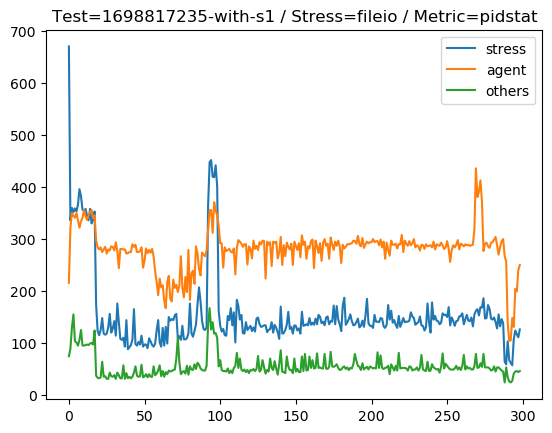

No handles with labels found to put in legend.


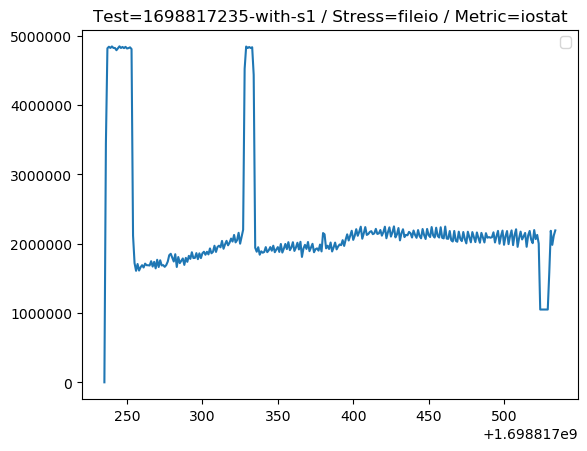

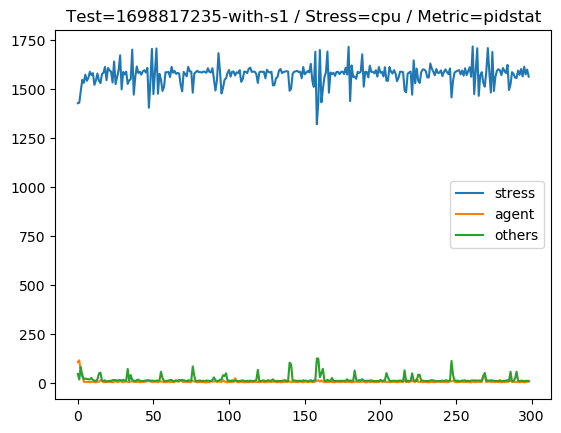

No handles with labels found to put in legend.


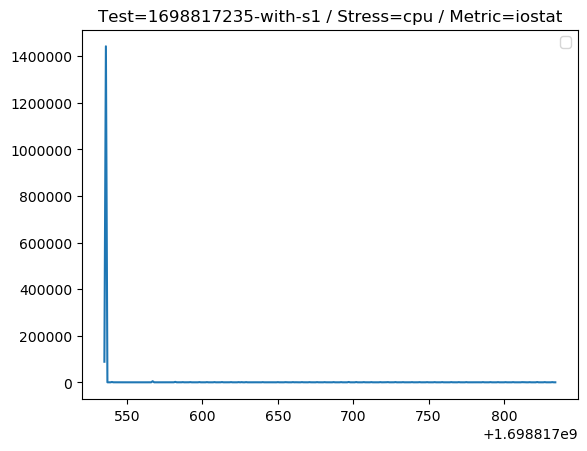

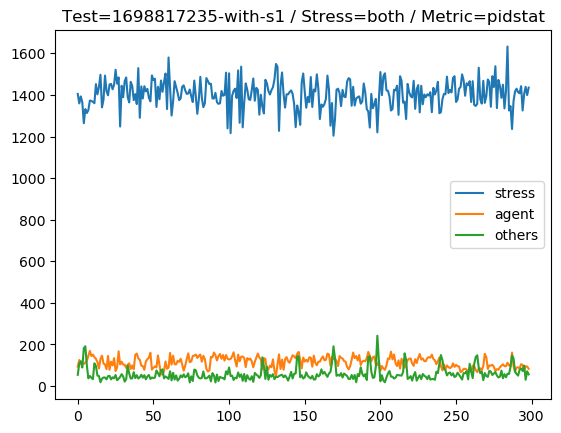

No handles with labels found to put in legend.


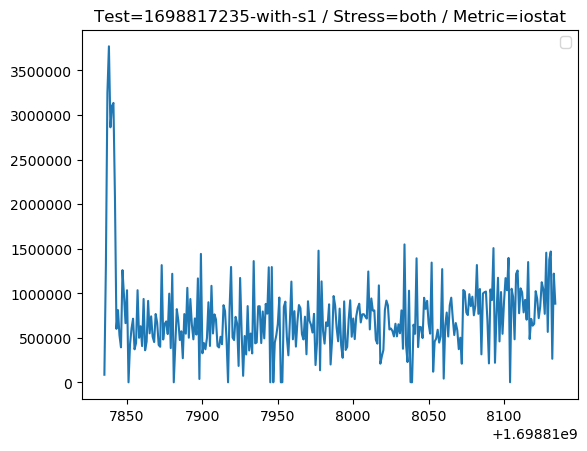

In [42]:
from matplotlib import pyplot as plt
import os
import shutil

shutil.rmtree('figures', ignore_errors=True)
os.mkdir('figures')

for report_name in report_names:
    for stress_kind in stress_kinds:
        for stat_kind in stat_kinds:
            x, y = graph_dict[report_name][stress_kind][stat_kind]
            if isinstance(y[0],dict):
                for key in y[0]:
                    y_value = list(map(lambda y:y[key], y))
                    plt.plot(y_value, label=key)
            else:
                plt.plot(x,y)
            plt.title(f'Test={report_name} / Stress={stress_kind} / Metric={stat_kind}')
            plt.legend()
            plt.savefig(f'figures/{report_name}-{stress_kind}-{stat_kind}.png')
            plt.show()
